In [1]:
import zipfile
import albumentations
import os

import random

from PIL import Image

import random

import sys
from tqdm.notebook import tqdm
from PIL import Image
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=UserWarning)
import numpy as np
import torch
from torch import nn
import albumentations as A

import cv2
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score



path = "documents_data.zip"
extract_path = "dataset_small"
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [175]:
def weight_init(model):
    """Initialises the model weights"""

    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

Total number of elements in the folder: 268


In [33]:
def print_while_trainig(epochs_list, loss_history, loss_history_overclustering):
    """
    Выводит значения потерь и потерь от перекластеризации

    Параметры
    ----------
    epochs_list : список целых чисел
        Эпохи, для которых доступны значения потерь.
    loss_history: список чисел
        Значения потерь, размер списка соответствует размеру epochs_list.
    loss_history_overclustering : список чисел с плавающей запятой
        Значения потерь от перекластеризации, размер списка соответствует размеру epochs_list.
    """


    clear_output(True)

    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_figwidth(12)

    ax1.plot(epochs_list, loss_history, label="train_loss")
    ax1.legend()
    ax1.grid()

    ax2.plot(
        epochs_list, loss_history_overclustering, label="train_loss_overclustering"
    )
    ax2.legend()
    ax2.grid()
    plt.show()

In [35]:
def compose_array_from_dataloader(dataloader, key="original"):
    """
    Создает массив numpy из даталоадера PyTorch.

    Параметры
    ----------
    dataloader : torch.utils.data.dataloader.DataLoader
        Исходный даталоадер, предоставляющий данные, которые будут преобразованы в массив numpy.
    key : str
        Определяет, что будет преобразовано.
        "original" — исходный набор данных,
        "augmented" — аугментированные (измененные) изображения,
        "label" — аннотации (метки).

    Возвращает
    -------
    output_array : numpy.array
        Выходной массив.
        Если параметр "key" равен "original" или "augmented", форма массива будет (N, H, W), где N = длина даталоадера, H и W — ширина и высота изображений.
        Если параметр "key" равен "label", форма выходного массива будет (N,), где N = длина даталоадера.
    """


    sample = dataloader.dataset[0][key]

    if key == "label":
        dtype = int
        output_shape = [len(dataloader.dataset)]
    else:
        dtype = np.float32
        output_shape = [len(dataloader.dataset)] + list(sample.shape)

    output_array = np.zeros(output_shape, dtype=dtype)
    output_array.setflags(write=True)
    global_batch_size = dataloader.batch_size

    with tqdm(total=len(dataloader)) as pbar:
        for idx, batch in enumerate(dataloader):
            array_to_add = batch[key].numpy()
            batch_size = array_to_add.shape[0]
            output_array[
                global_batch_size * idx : global_batch_size * idx + batch_size
            ] = array_to_add
            pbar.update(1)

    return output_array




In [36]:


def visualize_augmentations(dataset, samples=5, initial_idx=0):
    """
    Визуализирует несколько образцов из исходного набора данных и их аугментированные версии.

    Параметры
    ----------
    dataset : utils.NumpyAugDataset
        Набор данных с исходными и аугментированными (измененными) изображениями.
    samples : int
        Количество образцов для показа.
    initial_idx : int
        Начальный индекс. Отображаемые изображения имеют следующие индексы:
        initial_idx, initial_idx + 1, ..., initial_idx + samples.
    """


    figure, ax = plt.subplots(nrows=2, ncols=samples, figsize=(samples * 2, 4))

    for i in range(samples):
        images = dataset[initial_idx + i]
        original_image = images["original"]
        augmented_image = images["aug"]

        # Convert image shape from (C, H, W) to (H, W, C)
        original_image = original_image.transpose(1, 2, 0)
        augmented_image = augmented_image.transpose(1, 2, 0)

        # Ensure the images are in the correct range
        if original_image.max() > 1.0:
            original_image = original_image / 255.0
        if augmented_image.max() > 1.0:
            augmented_image = augmented_image / 255.0

        ax[0, i].imshow(original_image)
        ax[0, i].axis('off')
        ax[1, i].imshow(augmented_image)
        ax[1, i].axis('off')

    plt.tight_layout()
    plt.show()


In [39]:
alb_transforms = A.Compose(
    [
        A.IAAPerspective(scale=(0.01, 0.03), p=0.7),
        A.IAASuperpixels(p_replace=0.03, p=0.7),
        A.IAAAdditiveGaussianNoise(scale=(0.02 * 255, 0.05 * 255), p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.02, contrast_limit=0.02, p=0.7),
    ]
)

In [115]:


class AlbDataset(Dataset):
    def __init__(self, data_dir, alb_transforms=None):
        self.data_dir = data_dir
        self.alb_transforms = alb_transforms
        self.image_files = []
        self.labels = []
        self._scan_directory()

    def _scan_directory(self):
        for root, dirs, files in os.walk(self.data_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                    self.image_files.append(os.path.join(root, file))
                    label = int(os.path.basename(root))
                    self.labels.append(label)

    def set_transforms(self, transforms):
        self.alb_transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        image_np = np.array(image)

        if self.alb_transforms is not None:
            image_alb = self.alb_transforms(image=image_np)["image"]
            return {"original": image_np, "augmented": image_alb, "label": label}
        else:
                return {"original": image_np, "label": label}

In [116]:
def stratified_split(original_dataset, train_size, label_key="label"):
    """
    Разделяет общий датасет PyTorch на основе стратифицированного метода.
    Основан на функции sklearn.model_selection.train_test_split.
    Выходные наборы данных не содержат данных, но ссылаются на определенные индексы в исходном наборе данных.

    Параметры
    ----------
    original_dataset : torch.utils.data.dataset.Dataset или подобный
        Исходный датасет, который нужно разделить.
    train_size : float
        Доля данных, которая попадет в обучающий (первый возвращаемый) набор данных.
    label_key : str или int
        Ключ для доступа к метке из исходного набора данных.
        Если исходный набор данных возвращает словарь, это, вероятно, будет "label".
        Если исходный набор данных возвращает кортеж, то это должен быть целочисленный ключ, чаще всего равный 1.

    Возвращаемые значения
    ----------
    train_dataset : startifiedAgentDataset
        Обучающая часть разделенного набора. Размер определяется параметром train_size.
    test_dataset : startifiedAgentDataset
        Тестовая часть разделенного набора. Размер равен len(original_dataset) - train_size.
    """


    labels = [x[label_key] for x in original_dataset]
    indices = np.arange(len(labels))
    indices_and_labels = np.vstack([indices, labels]).transpose()
    train_indices_and_labels, test_indices_and_labels = train_test_split(
        indices_and_labels, train_size=train_size, stratify=labels
    )
    train_indices = train_indices_and_labels[:, 0].astype(int)
    test_indices = test_indices_and_labels[:, 0].astype(int)
    train_dataset = startifiedAgentDataset(original_dataset, train_indices)
    test_dataset = startifiedAgentDataset(original_dataset, test_indices)

    return train_dataset, test_dataset

In [117]:
class startifiedAgentDataset(Dataset):
    """
    Набор данных, создаваемый функцией stratified_split.
    Этот набор данных получает данные непосредственно из исходного экземпляра набора данных.
    Он может обращаться только к определенной части данных исходного набора данных.

    Атрибуты
    ----------
    original_dataset : torch.utils.data.dataset.Dataset или подобный
        Исходный набор данных, из которого берутся данные.
    indices_list : список
        Список индексов, которые могут быть доступны из исходного набора данных.
    """


    def __init__(self, original_dataset, indices_list):
        super().__init__()
        self.original_dataset = original_dataset
        self.indices_list = indices_list

    def __len__(self):
        return len(self.indices_list)

    def __getitem__(self, idx):
        original_idx = self.indices_list[idx]
        return self.original_dataset[original_idx]



In [118]:
def create_dataset_arrays(
    alb_transforms=None, aug_number=1, target_dir=".", batch_size=256, num_workers=1
):


    dataset_alb = AlbDataset(target_dir)
    dataloader = DataLoader(
        dataset_alb, batch_size=len(dataset_alb), shuffle=False, num_workers=num_workers
    )
    print(np.array(dataloader).shape)

    print("Fetching original dataset...", end=" ")
    originals_array = next(iter(dataloader))["original"].numpy()
    labels_array = next(iter(dataloader))["label"].numpy()
    print("Done!")

    dataset_alb.set_transforms(alb_transforms)
    aug_arrays = []
    dataloader = DataLoader(
        dataset_alb, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    for aug_idx in range(aug_number):
        print("Making aug #%i" % aug_idx)
        aug_arrays.append(compose_array_from_dataloader(dataloader, key="augmented"))

    return originals_array, labels_array, aug_arrays

In [180]:
class RAMAug(Dataset):
    """
    Набор данных, содержащий исходные и аугментированные данные в оперативной памяти.

    Атрибуты
    ----------
    original_dataset : numpy.ndarray
        Форма (N,...), где N — количество образцов данных, а "..." обозначает форму одного образца данных. Массив с исходными изображениями.
    labels : numpy.ndarray
        Форма (N,). Массив с метками классов.
    aug_datasets : список numpy.ndarray
        Список аугментированных  наборов данных, имеющих ту же форму, что и original_dataset.
    aug_number : int
        Количество аугментаций.
    """


    def __init__(
        self,
        augs_files=None,
        alb_transforms=A.Compose([]),
        aug_number=1,
        target_dir="./dataset",
        aug_batch_size=1024,
        aug_num_workers=1,
    ):
        """
        Инициализация набора данных

        Параметры
        ----------
        augs_files : список строк
            Список путей к бинарным файлам np (numpy) с аугментациями. Если этот параметр указан,
            другие параметры можно не передавать.
        alb_transforms : albumentations.core.composition.Compose
            Композиция преобразований Albumentations. Игнорируется, если указан параметр augs_files.
        aug_number : int
            Количество создаваемых аугментаций. Игнорируется, если указан параметр augs_files.
        target_dir : str
            Директория для хранения набора данных. Игнорируется, если указан параметр augs_files.
        batch_size : int
            Размер батча, используемого при аугментации. Игнорируется, если указан параметр augs_files.
        num_workers : int
            Количество потоков CPU для использования при аугментации. Игнорируется, если указан параметр augs_files.
        """


        if augs_files is not None:
            aug_number = 0

        self.original_dataset, self.labels, self.aug_datasets = create_dataset_arrays(
            alb_transforms=alb_transforms,
            aug_number=aug_number,
            target_dir=target_dir,
            batch_size=aug_batch_size,
            num_workers=aug_num_workers,
        )

        self.aug_number = aug_number

        if augs_files is not None:
            print("Loading augmented datasets...", end=" ")
            self.aug_datasets = [np.load(x) for x in augs_files]
            self.aug_number = len(augs_files)
            print("Done!")

    def save_augs(self, dataset_dir):
        

        print("Saving augs in %s..." % dataset_dir, end=" ")
        for aug_idx, aug_array in enumerate(self.aug_datasets):
            file_path = os.path.join(dataset_dir, "data_aug_" + str(aug_idx) + ".np")
            with open(file_path, "wb") as file:
                np.save(file, aug_array)
        print("Done!")

    def __len__(self):
        return self.original_dataset.shape[0]

    def __getitem__(self, idx):
        """
        Возвращает образец набора данных и индекс `idx`.

        Возвращаемые значения
        -------
        return_dict : dict
            Словарь с следующими ключами:
            "original" : numpy.ndarray
                Исходное изображение, взятое из self.original_dataset.
            "aug" : numpy.ndarray
                Аугментированное изображение, случайно выбранное из одного из self.aug_datasets.
            "label" : int
                Метка (label) изображения, взятая из self.labels.
        """

        type(idx)

        original_image = np.array(
            self.original_dataset[idx, :, :], copy=True, dtype=np.float32
        ).transpose(2,0,1)
        #print("or_img: ", original_image.transpose(0,3,1,2).shape)

        label = np.array(self.labels[idx], copy=True, dtype=np.float32)

        return_dict = {"original": original_image, "label": label}

        if self.aug_number > 0:
            aug_version = int(self.aug_number * random.random())
            aug_image = np.array(
                self.aug_datasets[aug_version][idx, :, :],
                copy=True,
                dtype=np.float32,
            ).transpose(2,0,1)
            #print("aug_img: ", aug_image.transpose(0,3,1,2).squeeze().shape)
            return_dict["aug"] = aug_image

        return return_dict

In [184]:
dataset_np = RAMAug(
    alb_transforms=alb_transforms,
    aug_number=5,
    target_dir="alekseev/augmented_data",
    aug_batch_size=256,
    aug_num_workers=11,
)

()
Fetching original dataset... Done!
Making aug #0


  0%|          | 0/78 [00:00<?, ?it/s]

Making aug #1


  0%|          | 0/78 [00:00<?, ?it/s]

Making aug #2


  0%|          | 0/78 [00:00<?, ?it/s]

Making aug #3


  0%|          | 0/78 [00:00<?, ?it/s]

Making aug #4


  0%|          | 0/78 [00:00<?, ?it/s]

In [185]:
dataset_train, dataset_val = stratified_split(dataset_np, train_size=0.95)

In [186]:
np.array(dataset_train).shape

(18884,)

In [187]:
BATCH_SIZE = 64
dataloader_train = DataLoader(
    dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=16
)
dataloader_val = DataLoader(
    dataset_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=16
)



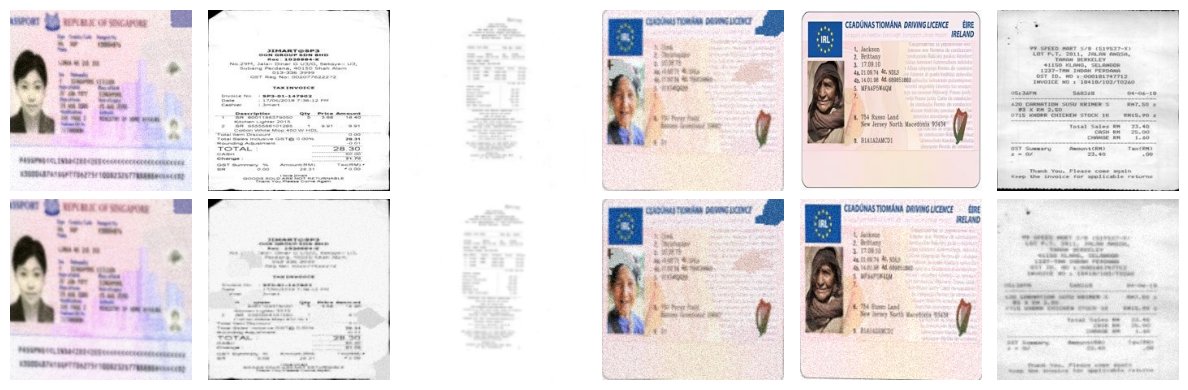

In [188]:
visualize_augmentations(dataset_train, samples=6)

In [189]:
resnet = models.resnet18(pretrained=False)

/media/sunveil/Data/header_detection/jupyter/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/sunveil/Data/header_detection/jupyter/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [190]:
modules_to_keep = list(resnet.children())[:-2]
print("The first layer:", modules_to_keep[0])

The first layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [191]:
modules_to_keep[0] = nn.Conv2d(
    3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
)

In [192]:
modules_to_keep.append(nn.Flatten())
backbone = nn.Sequential(*modules_to_keep)

In [193]:
batch = next(iter(dataloader_train))["original"]#.squeeze().permute(0,3,1,2)
batch = batch[0:3]

print("Batch shape:", batch.shape)

Batch shape: torch.Size([3, 3, 224, 224])


In [194]:
print("Output shape:", backbone(batch).shape)

Output shape: torch.Size([3, 25088])


In [195]:
final_features = 25088
cluster_head = nn.Linear(final_features, 3)
overcluster_head = nn.Linear(final_features, 15)

In [196]:
class ResNetClusterisator(nn.Module):
    """Кластеризатор для IIC на основе основы ResNet18"""

    def __init__(self):
        super(ResNetClusterisator, self).__init__()
        # число выходов, посчитанное заранее
        final_features = 25088

        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-2]
        modules[0] = nn.Conv2d(
            3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        modules.append(nn.Flatten())
        self.backbone = nn.Sequential(*modules)

        
        self.cluster_head = nn.Linear(final_features, 3)
        self.overcluster_head = nn.Linear(final_features, 30)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, overclustering=False):
    """Прямой запуск. Может работать как в режиме кластеризации, так и в режиме перекластеризации.

    Параметры
    ----------
    x : torch.tensor
        Входной батч.,
        где B — размер батча.
    overclustering : bool
        Если True, используется перекластеризации (overclustering head),
        в противном случае используется кластеризации (clustering head).
    """

        x = self.backbone(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)

        return self.softmax(x)

In [197]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using %s." % device)
model = ResNetClusterisator()
model.to(device)
print("The model is transfered to %s." % device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda.
The model is transfered to cuda.
The weights are Initialised.


In [198]:
print(batch.shape)

torch.Size([3, 3, 224, 224])


In [199]:
batch = next(iter(dataloader_train))["original"]
batch = batch.to(device)
print("Model output shape in clustering mode:", model(batch).shape)
print("Model output shape in overclustering mode:", model(batch).shape)

Model output shape in clustering mode: torch.Size([64, 3])
Model output shape in overclustering mode: torch.Size([64, 3])


In [200]:
def compute_joint(x_out, x_tf_out):
    """Оценивает совместное распределение вероятностей.

    Параметры
    ----------
    x_out : torch.tensor
        Форма (B, C), где B — размер батча, C — количество классов.
        Вероятности для исходного батча.
    x_out_tf : torch.tensor
        Та же форма, что и x_out.
        Вероятности для трансформированного батча.

    Возвращает
    -------
    p_i_j : torch.tensor
        Форма (C, C), где C — количество классов (такое же, как в x_out).
        Совместные вероятности.
    """

    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)  # bn, k, k

    p_i_j = p_i_j.mean(dim=0)

    p_i_j = (p_i_j + p_i_j.t()) / 2.0

    return p_i_j

In [201]:
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    """Вычисляет потерю взаимной информации. Общий минус добавлен, поэтому потеря должна быть минимизирована.

    Параметры
    ----------
    x_out : torch.tensor
        Форма (B, C), где B — размер батча, C — количество классов.
        Вероятности для исходного батча.
    x_out_tf : torch.tensor
        Та же форма, что и x_out.
        Вероятности для трансформированного батча.
    lambd : float
        Параметр, модифицирующий потерю.
        Больший lambd обычно побуждает модель к размещению
        выборок в различные кластеры равного размера.
        Меньший lambd побуждает модель к размещению похожих изображений в один кластер.
    EPS : float
        Параметр для регуляризации малых вероятностей.

    Возвращает
    -------
    loss : torch.tensor
        shape (1,). Потеря взаимной информации.
    """

    _, num_classes = x_out.size()

    p_i_j = compute_joint(x_out, x_tf_out)
    assert p_i_j.size() == (num_classes, num_classes)

    mask = ((p_i_j > EPS).data).type(torch.float32)
    p_i_j = p_i_j * mask + EPS * (1 - mask)

    p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes)
    p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes, num_classes)

    loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))

    loss = torch.sum(loss)

    return loss

In [202]:
batch = next(iter(dataloader_train))
print("Batch entities:", batch.keys(), end="\n\n")
print("Original images batch shape:     {0}".format(batch["original"].shape))
print("Transformed images batch shape:  {0}".format(batch["aug"].shape))
print("Labels batch shape:              {0}".format(batch["label"].shape))

Batch entities: dict_keys(['original', 'label', 'aug'])

Original images batch shape:     torch.Size([64, 3, 224, 224])
Transformed images batch shape:  torch.Size([64, 3, 224, 224])
Labels batch shape:              torch.Size([64])


In [203]:
inputs = batch["original"]
inputs_tf = batch["aug"]

inputs = inputs.to(device=device)
inputs_tf = inputs_tf.to(device=device)

In [204]:
overclustering = False
lamb = 1.0
outputs = model(inputs, overclustering)
outputs_tf = model(inputs_tf, overclustering)
loss = IID_loss(outputs, outputs_tf, lamb=lamb)
print(loss.data.cpu().numpy())
loss.backward()

-0.0008397531


In [205]:
def evaluate(
    model, dataloader, overclustering=False, lamb=1.0, device=torch.device("cpu")
):
    """Вычисляет среднюю потерю модели. Среднее значение берется по всем батчам."""

    losses = []
    model.eval()

    for i, batch in enumerate(dataloader):

        # forward run
        inputs = batch["original"]
        inputs_tf = batch["aug"]
        with torch.no_grad():

            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)

            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)

        loss = IID_loss(outputs, outputs_tf, lamb=lamb)

        losses.append(loss.data.cpu().numpy())

    return np.mean(losses)

In [206]:
def choose_clustering_regime(epoch, overcluster_period, overcluster_ratio):
    """Выбор режима кластеризации на основе номера эпохи.

    Параметры
    ----------
    epoch : int
        Текущий номер эпохи.
    overcluster_period : int
        Общий период для кластеризации и перекластеризации.
    overcluster_ratio : float
        Доля времени, которое нужно потратить на перекластеризацию.
    """


    if (
        overcluster_period is not None
        and epoch % overcluster_period < overcluster_period * overcluster_ratio
    ):
        return True
    else:
        return False

In [207]:
def IIC_train(
    modeldataset,
    dataloader,
    optimizer,
    epochs=100,
    device=torch.device("cpu"),
    eval_every=5,
    lamb=1.0,
    overcluster_period=20,
    overcluster_ratio=0.5,
):
    """Цикл обучения IIC 

    Параметры
    ----------
    model : ResNetClusterisator
        Модель IIC для обучения.
    dataloader : torch.utils.data.dataloader.DataLoader
        Даталоадер для получения данных.
    optimizer : torch.optim.optimizer или аналогичный
        Ваш любимый оптимизатор.
    epochs : int
        Общее количество эпох.
    device : torch.device
        Устройство, на котором должно выполняться обучение.
    eval_every : int
        Частота выполнения оценки (каждое n-е количество эпох).
    lamb : float
        Параметр для модификации потерь IID (см. IID_loss).
    overcluster_period : int
        Общий период для кластеризации и перекластеризации.
    overcluster_ratio : float
        Доля времени, которую следует уделить перекластеризации.
    """


    epochs_list = []
    loss_history = []
    loss_history_overclustering = []

    # Variables for best losses
    best_cluster_loss = 0
    best_overcluster_loss = 0

    pbar = tqdm(total=len(dataloader), leave=False, desc="Epoch")

    for epoch in range(epochs):

        model.train()
        overclustering = choose_clustering_regime(
            epoch, overcluster_period, overcluster_ratio
        )

        pbar.reset()
        pbar.desc = "Epoch #%i" % epoch

        for i, batch in enumerate(dataloader):

            optimizer.zero_grad()

            # Forward run
            inputs = batch["original"]
            inputs_tf = batch["aug"]

            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)

            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
            loss = IID_loss(outputs, outputs_tf, lamb=lamb)

            # Backward run
            loss.backward()

            # Updating the weights
            optimizer.step()

            # Updating the progreess bar
            pbar.update(1)

        if (epoch + 1) % eval_every == 0:

            # Computing eval losses
            loss_eval = evaluate(
                model, dataloader, overclustering=False, lamb=lamb, device=device
            )
            loss_eval_overclustering = evaluate(
                model, dataloader, overclustering=True, lamb=lamb, device=device
            )

            loss_history.append(loss_eval)
            loss_history_overclustering.append(loss_eval_overclustering)
            epochs_list.append(epoch)

            if loss_eval < best_cluster_loss:
                best_cluster_loss = loss_eval
                torch.save(model.state_dict(), "best_loss_model")

            pbar.close()

            print_while_trainig(epochs_list, loss_history, loss_history_overclustering)

            pbar = tqdm(total=len(dataloader), leave=False, desc="Epoch")

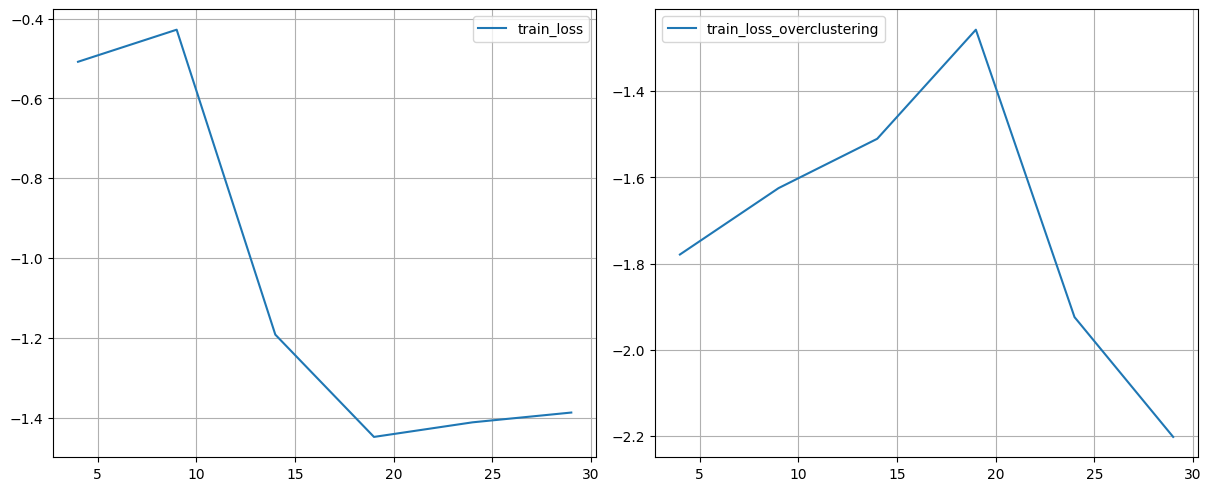

Epoch:   0%|          | 0/296 [00:00<?, ?it/s]

In [208]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=4e-4,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
)
IIC_train(
    model,
    dataloader_train,
    optimizer,
    device=device,
    epochs=30,
    lamb=1.2,
    overcluster_period=20,
    overcluster_ratio=0.5,
)

In [209]:
model.load_state_dict(torch.load("best_loss_model"))

<All keys matched successfully>

In [210]:
def get_cluster_labeling(model, dataloader, device=torch.device("cpu")):
    """Назначение кластерных меток для данных из даталоадера.

        Параметры
        ----------
        model : resnetModel
            Модель, выполняющая кластеризацию.
        dataloader : torch.utils.data.dataloader.DataLoader
            Даталоадер с данными для кластеризации.
        device : torch.device
            Устройство, на котором будет выполняться кластеризация.

        Возвращает
        ----------
        answers : dict
            Словарь с двумя ключами:
            original_labels : список целых чисел
                Исходные метки из набора данных.
            cluster_labels : список целых чисел
                Метки, полученные от модели.
    """

    model.eval()
    original_labels = []
    cluster_labels = []
    for batch in dataloader:
        images = batch["original"].to(device)
        labels = batch["label"].to(device)
        outputs = model(images, False)
        original_labels += labels.tolist()
        cluster_labels += torch.argmax(outputs, dim=1).tolist()
    return original_labels, cluster_labels


def visualise_clusetering_results(original_labels, cluster_labels, figwidth=20):
    """Визуализация результатов кластеризации
        Показывает, как изображения с определенными исходными метками распределяются после кластеризации.

        Параметры
        ----------
        original_labels : список целых чисел
            Список исходных меток.
        cluster_labels : список целых чисел
            Список меток, полученных от кластеризатора.
        figwidth : int, необязательный
            Ширина фигуры matplotlib (plt.figure).
    """


    original_labels = np.array(original_labels)
    cluster_labels = np.array(cluster_labels)
    class_ids = np.unique(original_labels)
    fig, axes = plt.subplots(2, 5, constrained_layout=True)
    fig.set_figwidth(figwidth)

    for idx, ax in enumerate(axes.reshape(-1)):
        labels_distribution = original_labels[cluster_labels == idx]
        counts = np.array([np.sum(labels_distribution == i) for i in range(10)])
        ax.bar(list(range(10)), counts)
        ax.set_xticks(np.arange(10))
        ax.set_xlim([0, 9])
        ax.set_title("Original label: %i" % idx)

In [211]:
original_labels, cluster_labels = get_cluster_labeling(
    model, dataloader_train, device=device
)

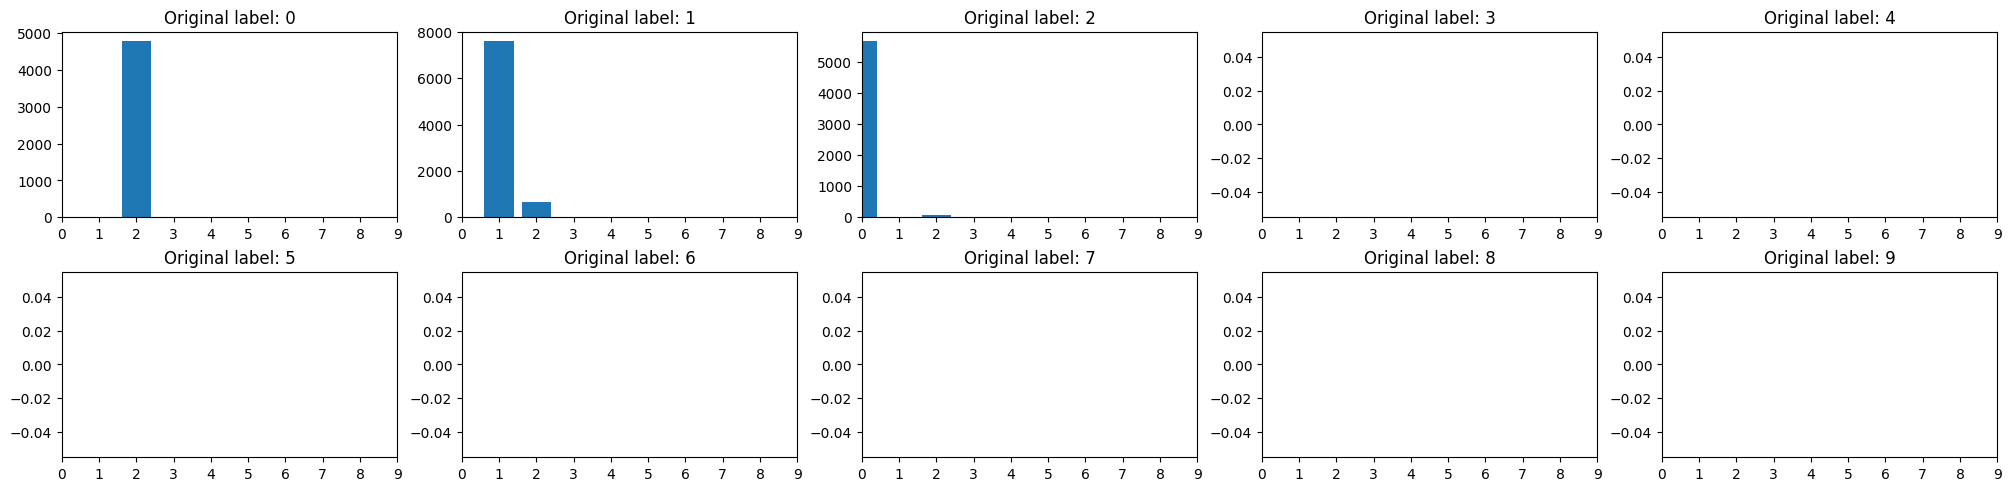

In [212]:
visualise_clusetering_results(original_labels, cluster_labels)

In [213]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)


Adjusted rand score: 0.884 
Homogeneity score: 0.884 
Completeness score: 0.861


In [218]:
original_labels, cluster_labels = get_cluster_labeling(
    model, dataloader_val, device=device
)

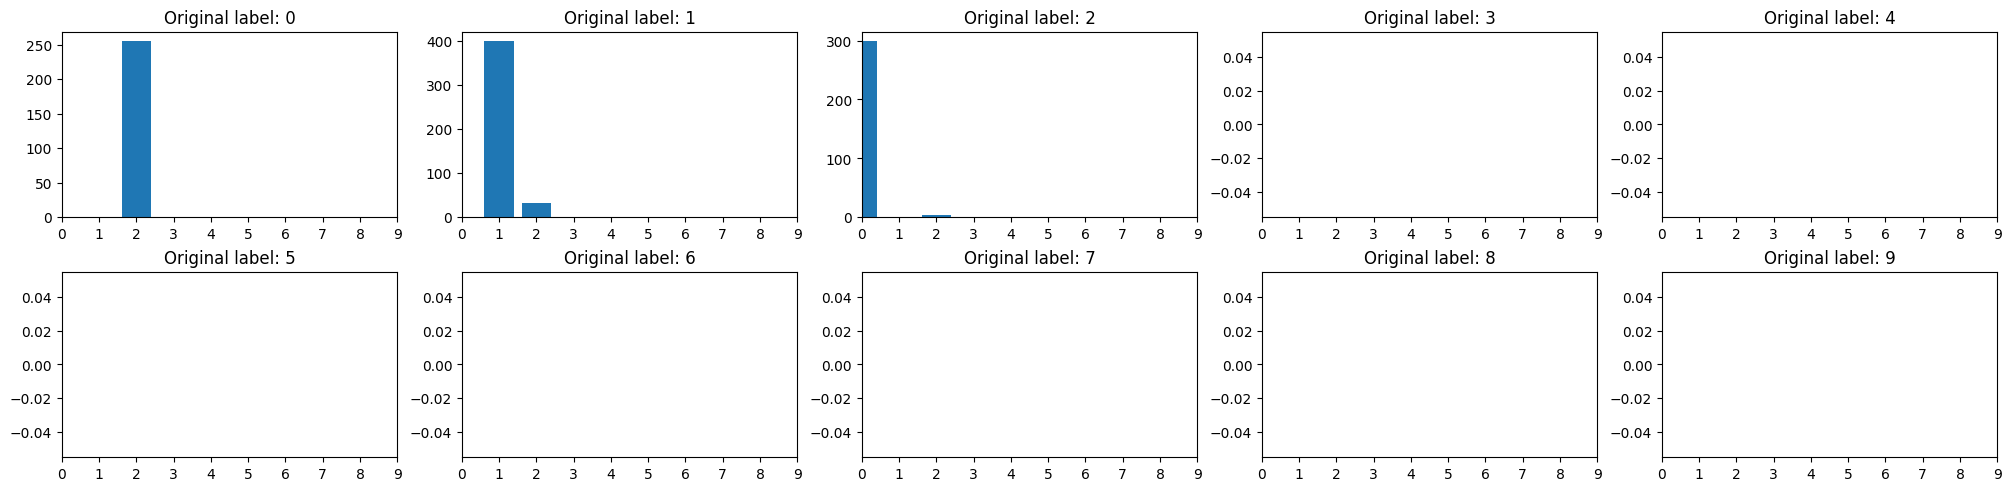

In [219]:
visualise_clusetering_results(original_labels, cluster_labels)

In [220]:

def create_mapping(original_labels, cluster_labels):
    """Создает соответствие (mapping) от кластерных меток к исходным меткам.
    В каждом кластере выбирается наиболее частая исходная метка. Эта метка считается истинной меткой кластера.

    Параметры
    ----------
    original_labels : список целых чисел
        Истинные метки данных.
    cluster_labels : список целых чисел
        Метки, полученные в результате работы алгоритма кластеризации.

    Возвращает
    -------
    mapping : dict
        Сопоставление от кластеров к исходным классам.
    """


    original_labels = np.array(original_labels, dtype=int)
    cluster_labels - np.array(cluster_labels, dtype=int)
    class_ids = np.unique(original_labels)
    cluster_ids = np.unique(cluster_labels)
    mapping = {}
    for cluster_id in cluster_ids:
        original_labels_in_cluster = original_labels[cluster_labels == cluster_id]
        map_to_id = np.bincount(original_labels_in_cluster).argmax()
        mapping[cluster_id] = map_to_id

    return mapping

def print_mapping(mapping):
    """Визуализирует соответствие кластерных меток и исходных меток.

    Параметры
    ----------
    mapping : dict (int к int)
        Сопоставление от кластерных меток к исходным классам.
    """

    print("Cluster  Class")
    for key, value in mapping.items():
        print("%3i -----> %i" % (key, value))

In [221]:
cluster_mapping = create_mapping(original_labels, cluster_labels)
cluster_labels_mapped = [cluster_mapping[x] for x in cluster_labels]
print_mapping(cluster_mapping)

Cluster  Class
  0 -----> 2
  1 -----> 1
  2 -----> 0


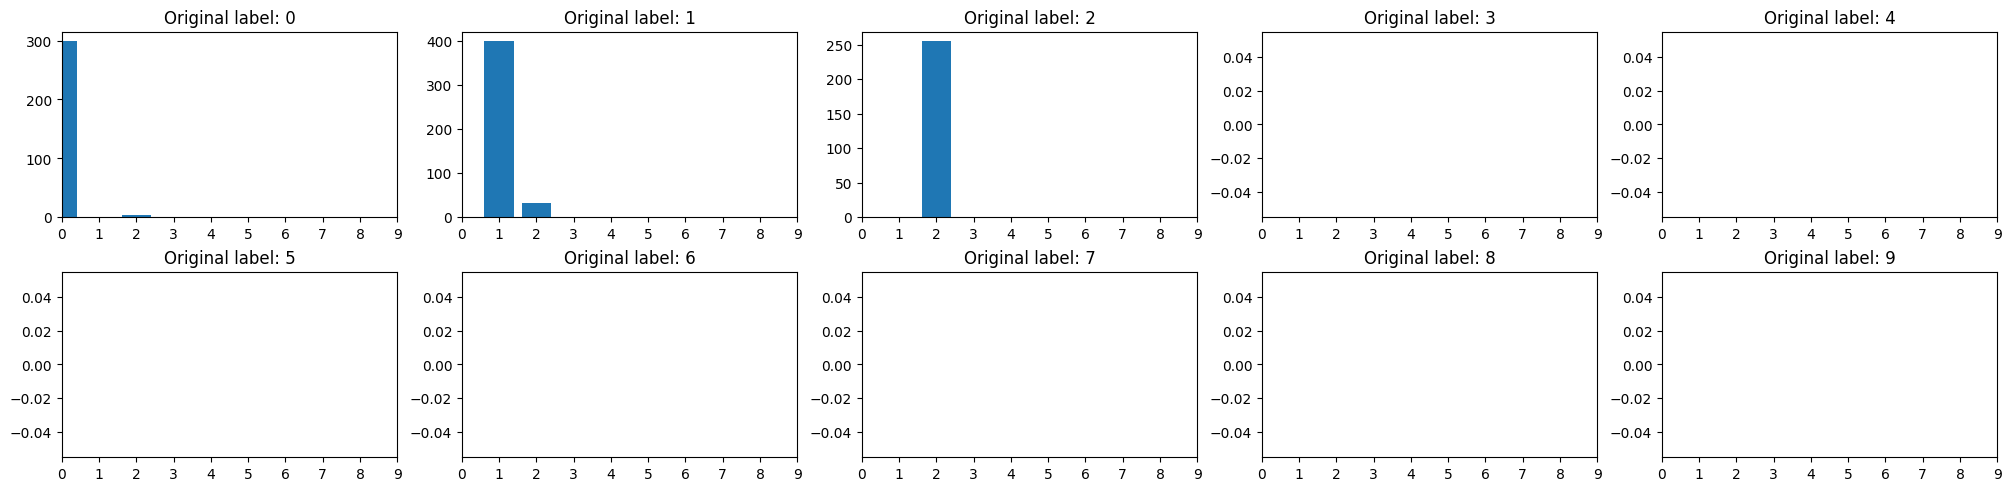

In [222]:
visualise_clusetering_results(original_labels, cluster_labels_mapped)

In [223]:
accuracy_score(original_labels, cluster_labels_mapped)

0.9627766599597586